In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting the data 
import seaborn as sns # Advanced data plotting on top of matplotlib
import os


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import cv2
from PIL import Image
from PIL import ImageDraw
from matplotlib import pyplot as plt


import pickle
from tqdm import tqdm
import math

In [2]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
#/kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv
#/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv
#/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv
#/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv    

**About data**

*images* - a folder of images corresponding to each article_id; images are placed in subfolders starting with the first three digits of the article_id; note, not all article_id values have a corresponding image.

*articles.csv* - detailed metadata for each article_id available for purchase

*customers.csv* - metadata for each customer_id in dataset

*sample_submission.csv* - a sample submission file in the correct format

*transactions_train.csv* - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. Your task is to predict the article_ids each customer will purchase during the 7-day period immediately after the training data period.

*target*: Make predictions for all customer_id values found in the sample submission. All customers who made purchases during the test period are scored, regardless of whether they had purchase history in the training data.

Submissions are evaluated according to the Mean Average Precision @ 12 (MAP@12).
For each customer_id observed in the training data, you may predict up to 12 labels for the article_id, which is the predicted items a customer will buy in the next 7-day period after the training time period. 

# EDA

In [3]:
#customers_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv")
#sample_submission = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv" )
#customers_df.head()

In [4]:
#transactions_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")#, nrow=10000)
#print(transactions_df.shape)
#transactions_df.head()
# let's takr peace of data
#transactions_df_sample = transactions_df.iloc[:50000,:].copy()
#transactions_df_sample.shape

In [5]:
articles_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv")
print(articles_df.shape)
articles_df.head().T  

(105542, 25)


,0,1,2,3,4
article_id,108775015,108775044,108775051,110065001,110065002
product_code,108775,108775,108775,110065,110065
prod_name,Strap top,Strap top,Strap top (1),OP T-shirt (Idro),OP T-shirt (Idro)
product_type_no,253,253,253,306,306
product_type_name,Vest top,Vest top,Vest top,Bra,Bra
product_group_name,Garment Upper body,Garment Upper body,Garment Upper body,Underwear,Underwear
graphical_appearance_no,1010016,1010016,1010017,1010016,1010016
graphical_appearance_name,Solid,Solid,Stripe,Solid,Solid
colour_group_code,9,10,11,9,10
colour_group_name,Black,White,Off White,Black,White


In [6]:
def make_image_path(image_id):
    return "../input/h-and-m-personalized-fashion-recommendations/images/0{}/0{}.jpg".format(str(image_id)[:2], image_id)

In [7]:
# will use small sample
#articles_df_sample = articles_df.head(500).copy()
articles_df_sample = articles_df.head(20000).copy()

In [8]:
# make path
articles_df_sample["image_path"] = articles_df_sample["article_id"].apply(make_image_path)
articles_df_sample["image_path"].head()

0    ../input/h-and-m-personalized-fashion-recommen...
1    ../input/h-and-m-personalized-fashion-recommen...
2    ../input/h-and-m-personalized-fashion-recommen...
3    ../input/h-and-m-personalized-fashion-recommen...
4    ../input/h-and-m-personalized-fashion-recommen...
Name: image_path, dtype: object

# Image Similarity

In [9]:
image_path = make_image_path(articles_df_sample.sample(6)['article_id'].values[0])
        #print(image_path)
img = Image.open(image_path)


In [10]:
def draw_images(image_ids):
    img_list = []
    for id in image_ids:
        #image_path = "../input/h-and-m-personalized-fashion-recommendations/images/0{}/0{}.jpg".format(str(id)[:2], id)
        image_path = make_image_path(id)
        #print(image_path)
        
        try:
            img = Image.open(image_path)
        except FileNotFoundError:
            img = Image.new(mode="RGBA", size=(50,50), color="red") 
            
            
        img_list.append(img)

    plt.figure(figsize=(20,5))
    for j in range(len(image_ids)):
        plt.subplot(1, len(image_ids), j+1)
        plt.axis('off')
        plt.imshow(img_list[j])
        plt.title(str(image_ids[j]), loc='center')

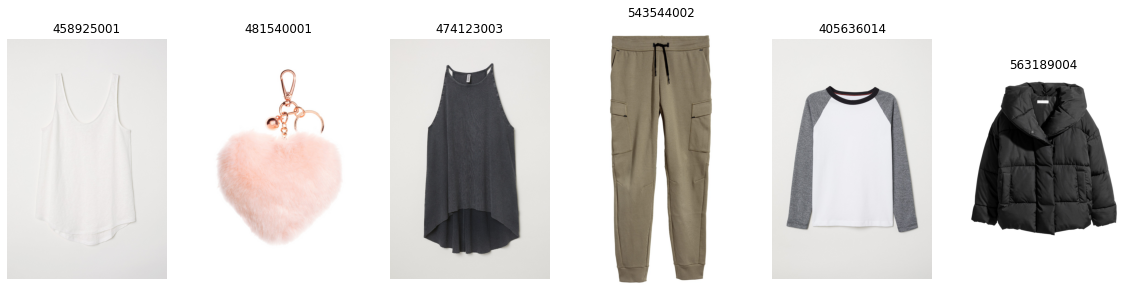

In [11]:
# image examples
draw_images(articles_df_sample.sample(6)['article_id'].values)

# Model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

In [13]:
#from PIL import Image

black_set = set() 
from torchvision import transforms


transform_resnet = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


class HMDataset_resnet(Dataset):
    
    def __init__(self, imgs_list, transforms = None):
        
        super().__init__()
        self.imgs_list = imgs_list
        self.transforms = transforms
        
        
    def __getitem__(self, index):
    
       
        image_path = self.imgs_list[index]
       
        #Reading image
        try:
            input_image = Image.open(image_path)
        except FileNotFoundError:
            #print("FileNotFoundError:", image_path, " black_image will be used instead of it!")
            image_path = "../input/black-image/A_black_image.jpg"
            input_image = Image.open(image_path)
            black_set.add(image_path.split("/")[-1][:-4])
        
        if input_image.mode != 'RGB':
            #print("No RGB!")
            black_set.add(image_path.split("/")[-1][:-4])
            
            image_path = "../input/black-image/A_black_image.jpg"
            input_image = Image.open(image_path)
            
        
        if self.transforms:
            image = self.transforms(input_image)
            
        
        return image
        
        
        
    def __len__(self):
        return len(self.imgs_list)

In [14]:
#  For RESNET
img_tensors = HMDataset_resnet(articles_df_sample.image_path.values, transform_resnet)

img_data_loader = DataLoader(
    dataset = img_tensors,
    batch_size = 16,
    shuffle=False,
    #sampler = train_random_sampler,
    num_workers = 2,
)

In [15]:
#black_set
#articles_df_sample.image_path.values[1634*16+4]
#img = Image.open(articles_df_sample.image_path.values[1634*16+4])
#print(img.mode)
#plt.imshow(img)

In [16]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [17]:
# dummy layer for replace classification layer in model

class Identity(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x
    
model.fc = Identity()

In [18]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# make embedings of the pictures

img_embs_list = []
for batch in tqdm(img_data_loader):
    try:
        img_embs = model(batch)
        img_embs_list += list(img_embs.detach().numpy())#astype(np.float32)
    except RuntimeError:
        img_embs_list += [np.zeros(512) for i in range(16)] #astype(np.float32)
        
len(img_embs_list)

# or load them
#with open ('img_embedings', 'rb') as fp:
#    img_embs_list = pickle.load(fp)

100%|██████████| 1250/1250 [20:15<00:00,  1.03it/s]


20000

In [20]:
len(img_embs_list)

20000

In [21]:
black_set

set()

In [22]:
# save embedings

with open('img_embedings', 'wb') as fp:
    pickle.dump(img_embs_list, fp)

In [23]:
# calculate most similar embedings 

def image_similarity_top_n(img_embs_list, img_num, n):
    
    if img_num > len(img_embs_list):
        return []
    
    img_cor_list = []
    for img_emb in img_embs_list:
        
        try:
            img_cor = np.correlate(img_embs_list[img_num], img_emb)
        except IndexError:
            #print("IndexError")
            img_cor = [0]
            
        img_cor_list.append(img_cor[0])
        
    #print(img_cor_list[:3])
    return np.argsort(img_cor_list)[-n-1:-1]

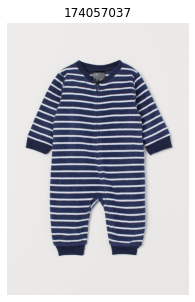

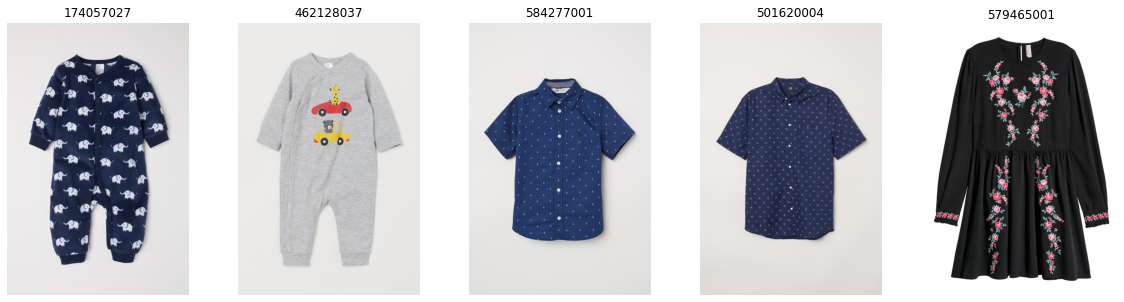

In [24]:
item_num = 95
draw_images([articles_df_sample.iloc[item_num,0]])
id_list = []
for i in image_similarity_top_n(img_embs_list, item_num, 5):
    id_list.append(articles_df_sample.iloc[i,0])
draw_images(id_list)

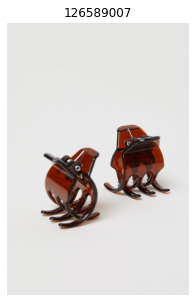

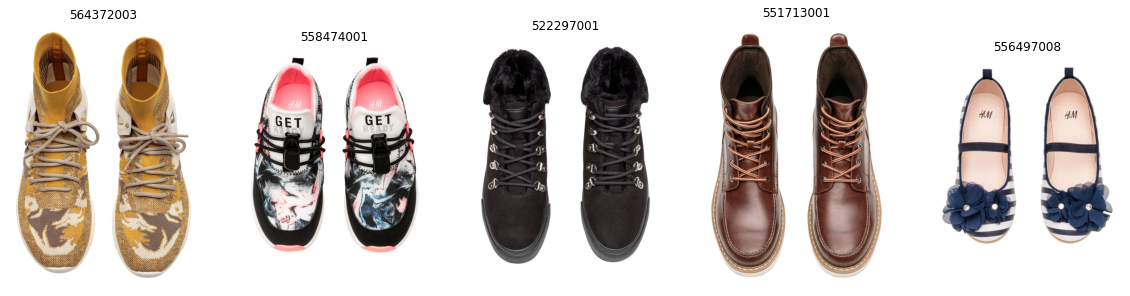

In [25]:
item_num = 29
draw_images([articles_df_sample.iloc[item_num,0]])
id_list = []
for i in image_similarity_top_n(img_embs_list, item_num, 5):
    id_list.append(articles_df_sample.iloc[i,0])
draw_images(id_list)

In [26]:
customer_test_df = pd.read_csv("../input/fork-of-h-m-recsys-eda-and-split/customer_test.csv")
customer_test_df.head()

customer_test_df_open_transactions = pd.read_csv("../input/fork-of-h-m-recsys-eda-and-split/customer_test_df_open_transactions.csv")
customer_test_df_open_transactions.head()

,Unnamed: 0,customer_id,t_dat,article_id,price,sales_channel_id
0,0,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,2018-09-20,501820043,0.016932,2
1,1,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,2018-09-20,501820043,0.016932,2
2,2,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,2018-09-20,674681001,0.008458,2
3,3,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,2018-09-20,671505001,0.033881,2
4,4,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,2018-09-20,671505001,0.033881,2


In [27]:
#black_set = set()
full_pred_list = []

# go through all customers from test list
for k, customer in enumerate(customer_test_df.customer_id):
    
    
    # go through all purchases of customers
    customer_pred = []
    for id in customer_test_df_open_transactions[customer_test_df_open_transactions.customer_id == customer].article_id:
        
        # if no image for this id go next
        if (id in black_set):
            continue
        
        article_index = articles_df[articles_df.article_id == id].index.values[0]
        #print(article_index)
        
        if article_index > len(img_embs_list):
            continue
        
        # for every item predict 12 items
        article_index_pred = []
        for item in image_similarity_top_n(img_embs_list, article_index, 12):
            article_index_pred.append(articles_df_sample.iloc[item,0])
        
        customer_pred += article_index_pred
        
        
        
    print(k, customer, len(customer_pred), len(np.unique(customer_pred)), np.unique(customer_pred)[:4])
        
    full_pred_list.append(np.unique(customer_pred))    
    
    
print(full_pred_list[0])

#id_list = []
#for i in image_similarity_top_n(img_embs_list, item_num, 12):
#    id_list.append(articles_df_sample.iloc[i,0])
#full_id_list.append(id_list)


with open('img_preds', 'wb') as fp:
    pickle.dump(full_pred_list, fp)

0 000aa7f0dc06cd7174389e76c9e132a67860c5f65f970699daccc14425ac31a8 24 12 [244267032 375849019 405586006 519749040]
1 001521e8394eb81ba43ab5b84ae7e756d51ac813be212a96e8779e0e42c029c0 120 63 [201219013 244267032 283236020 287645027]
2 00294f5274dbc84408d60fc661860d385c2901dccca8c4145cccb90d63ef2b82 264 175 [297898002 310091014 352811033 366859033]
3 002975c14a1aecac230ebf40c314fcad04ee3140e9bef259acc390c3fac257cb 108 89 [237347060 244267032 250457010 283236020]
4 002e0bc901590e07341001b2358bded94031771537c24b6a7805c9b82cc95a1a 72 64 [146730001 304778009 310091014 373506026]
5 0063a5fab642a52b80dcc5561b3a2ef5a06f13f2967a7a9ba7672d139969424c 48 43 [412964023 416961019 458428033 459756011]
6 00a5601e1e207751fefbfc0c00006454e20a571a2dbdd1241cc5149eb4791ab3 228 154 [141661022 244267032 268450034 283236020]
7 0162c0eacae80811a6b926cb3432888bc3f5fffb963b66f4d250b5e9682a7cf2 36 23 [310091014 352811033 454143003 458428031]
8 01a654dd9975ab239e1aacceb81dba8ca3a2208cfe3aef527648acb3178115ea 0 0 []


In [28]:
len(full_pred_list)

500

In [29]:
black_set

set()

In [30]:
full_pred_list[3]

array([237347060, 244267032, 250457010, 283236020, 352811033, 355307052,
       387348025, 405586006, 416961019, 452616001, 453988030, 458428031,
       462128021, 462128037, 478992004, 478992009, 480627011, 480627025,
       484767012, 501620004, 501620027, 505507006, 506321002, 506494001,
       508929051, 508929053, 508929054, 508929068, 508935028, 509017001,
       510220001, 513739001, 515133002, 522398065, 522561001, 535478001,
       536139046, 536139069, 540277017, 540395003, 545999001, 545999002,
       547777009, 547987009, 549252001, 549263008, 552315001, 552643001,
       554011013, 554546001, 554546002, 554546003, 555366001, 556527009,
       556559001, 556560002, 557908013, 558513001, 558514003, 558981004,
       558996001, 560846001, 561273001, 564786001, 564999002, 565329001,
       565379005, 565379023, 567992017, 568505004, 568962001, 570719001,
       572797010, 573149001, 573150001, 573410004, 573635001, 574212001,
       576558001, 577431001, 578023001, 578041001, 

3e60da3d0bb7a3af7fffd21774b08d31f8e5700e99ade4256d812db07e0a0969


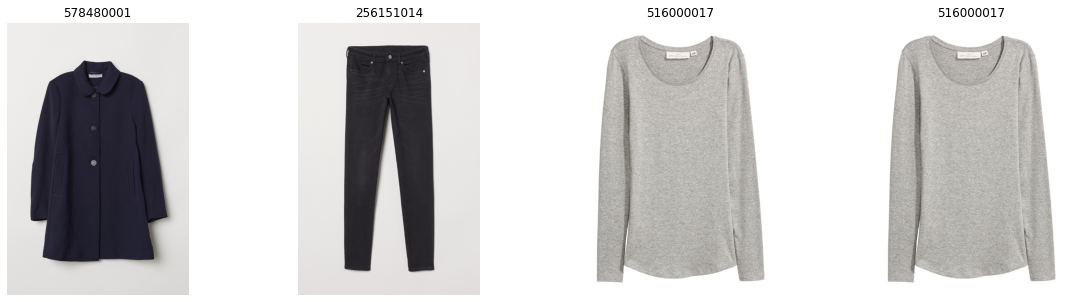

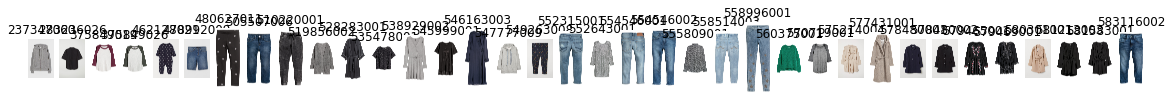

In [31]:
i = 282
customer = customer_test_df.customer_id[i]
print(customer)
id_list = customer_test_df_open_transactions[customer_test_df_open_transactions.customer_id == customer].article_id
#print(id_list.values)
draw_images(id_list.values)
draw_images(full_pred_list[i])

5d1e58e60d11e2462fcaee7b9ab7979e9cebf16cc65bd6eb22e258d102e99218


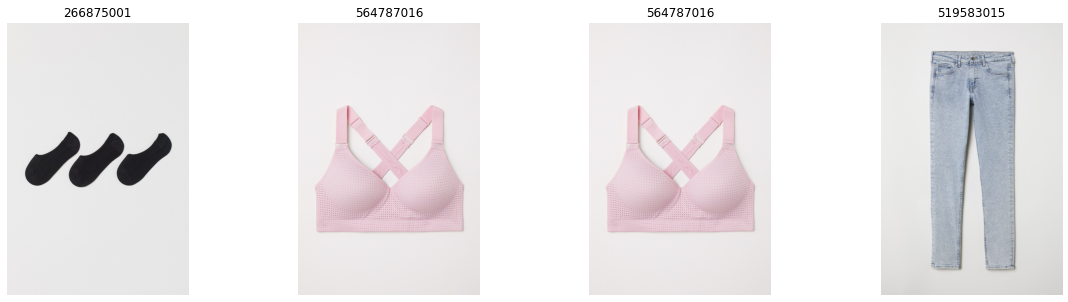

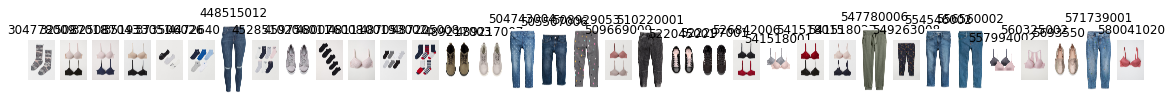

In [32]:
i = 448
customer = customer_test_df.customer_id[i]
print(customer)
id_list = customer_test_df_open_transactions[customer_test_df_open_transactions.customer_id == customer].article_id
#print(id_list.values)
draw_images(id_list.values)
draw_images(full_pred_list[i])

00a5601e1e207751fefbfc0c00006454e20a571a2dbdd1241cc5149eb4791ab3


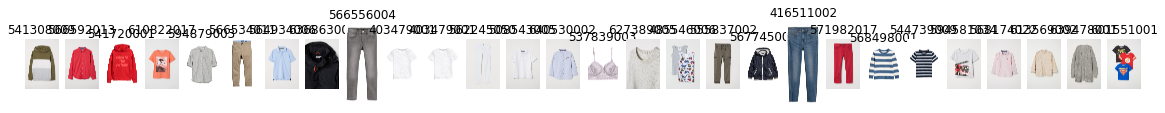

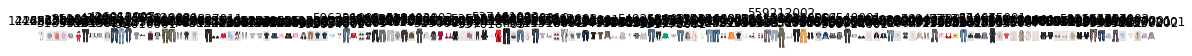

In [33]:
i = 6
customer = customer_test_df.customer_id[i]
print(customer)
id_list = customer_test_df_open_transactions[customer_test_df_open_transactions.customer_id == customer].article_id
#print(id_list.values)
draw_images(id_list.values)
draw_images(full_pred_list[i])

03745a067be8306fe4808f7df3a905e0ab6508eed8b2ff4f4e937db3b2c47e16


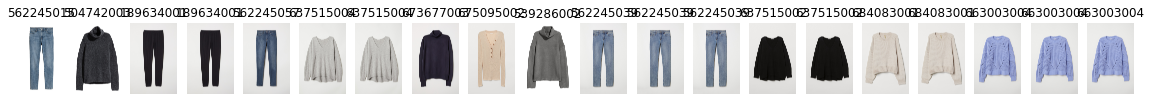

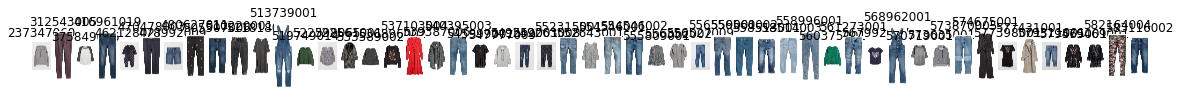

In [34]:
i = 15
customer = customer_test_df.customer_id[i]
print(customer)
id_list = customer_test_df_open_transactions[customer_test_df_open_transactions.customer_id == customer].article_id
#print(id_list.values)
draw_images(id_list.values)
draw_images(full_pred_list[i])

04050a0433c9050f619b3b54ac4b63c14a2d8b5afe121e63f04cfa739eb7eac7


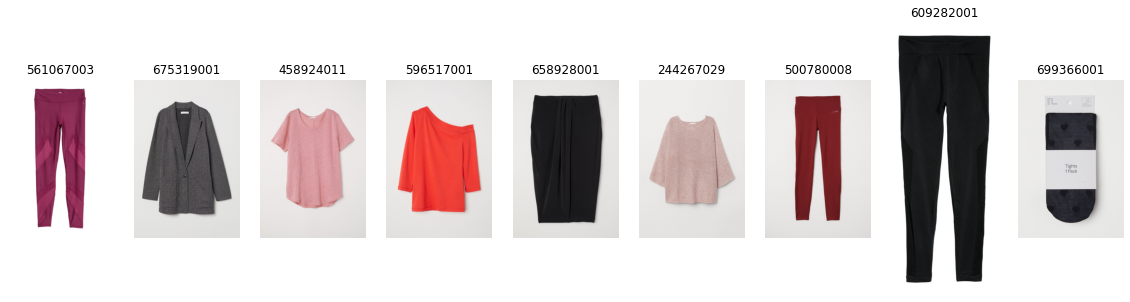

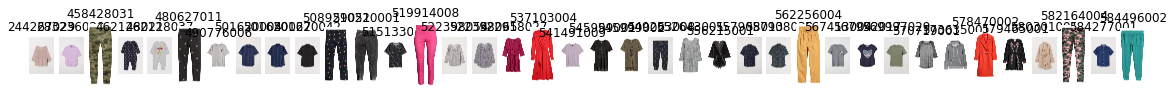

In [35]:
i = 16
customer = customer_test_df.customer_id[i]
print(customer)
id_list = customer_test_df_open_transactions[customer_test_df_open_transactions.customer_id == customer].article_id
#print(id_list.values)
draw_images(id_list.values)
draw_images(full_pred_list[i])

67a84660743ba09cc4784425465efd354b153cd1fb0d344bb0c18164f4553b56


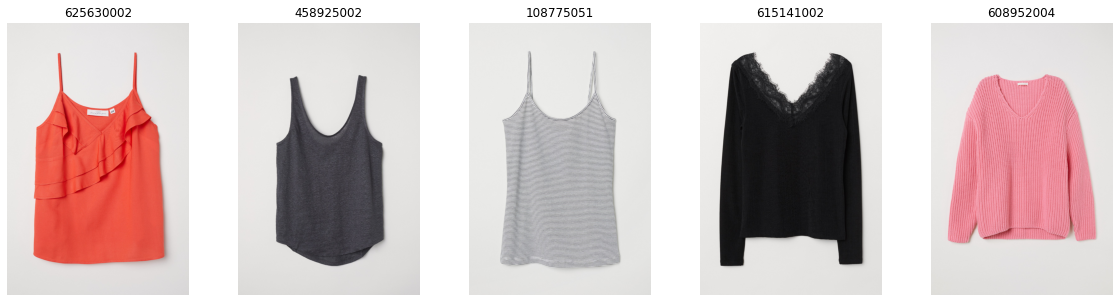

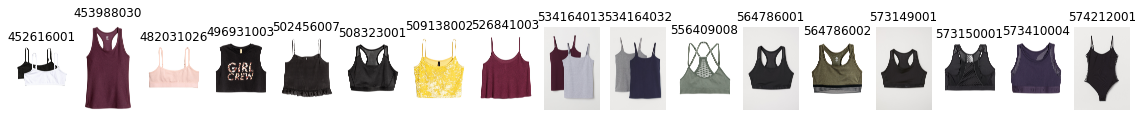

In [36]:
i = 498
customer = customer_test_df.customer_id[i]
print(customer)
id_list = customer_test_df_open_transactions[customer_test_df_open_transactions.customer_id == customer].article_id
#print(id_list.values)
draw_images(id_list.values)
draw_images(full_pred_list[i])

In [37]:
#with open ('./img_preds', 'rb') as fp:
#    img_preds = pickle.load(fp)
    
#img_preds